# Semi-synthetic Spellmatch weighting parameter sensitivity analysis

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

## Algorithm convergence

In [2]:
scores_info = pd.read_csv("results/scores.csv")
source_desc = scores_info["points_file_name"].str.split("[_\.]", regex=True)
df = pd.DataFrame(
    data={
        "is_dense": source_desc.str[0] == "dense",
        "is_heterogeneous": source_desc.str[1] == "heterogeneous",
        "use_prior": scores_info["spellmatch_alpha"] != 1.0,
        "use_degrees": scores_info["spellmatch_degree_weight"] != 0.0,
        "use_intensities": scores_info["spellmatch_intensity_weight"] != 0.0,
        "use_distances": scores_info["spellmatch_distance_weight"] != 0.0,
        "converged": scores_info["error"].isna(),
    }
)

In [3]:
x = df.drop(columns="converged")
y = df["converged"]
rfc = RandomForestClassifier(bootstrap=False, random_state=123).fit(x, y)
rfc.score(x, y)

0.9755859375

In [4]:
pd.Series(rfc.feature_importances_, index=rfc.feature_names_in_, name="Gini importance").sort_values(ascending=False)

use_prior           0.626063
is_dense            0.269771
is_heterogeneous    0.045693
use_distances       0.022108
use_degrees         0.021648
use_intensities     0.014717
Name: Gini importance, dtype: float64

In [5]:
df.groupby("use_prior")["converged"].mean()

use_prior
False    0.500000
True     0.994792
Name: converged, dtype: float64

In [6]:
df.groupby(["use_prior", "is_dense"])["converged"].mean().to_frame(name="frac_converged").reset_index()\
    .pivot(index="use_prior", columns="is_dense", values="frac_converged")

is_dense,False,True
use_prior,,
False,0.125,0.875000
True,1.000,0.989583


In [7]:
# # Forward selection using logistic regression (same result)

# remaining_cols = [col for col in df if col != "converged"]
# col_order = []
# scores = []
# while len(remaining_cols) > 0:
#     next_best_col = None
#     next_best_score = -float("inf")
#     for col in remaining_cols:
#         x = df[col_order + [col]]
#         y = df["converged"]
#         estimator = LogisticRegression().fit(x, y)
#         score = estimator.score(x, y)
#         if score > next_best_score:
#             next_best_col = col
#             next_best_score = score
#     col_order.append(next_best_col)
#     scores.append(next_best_score)
#     remaining_cols.remove(next_best_col)

# xs = range(len(scores) + 1)
# ys = [0] + scores
# col_features = {
#     "is_dense": "density",
#     "is_heterogeneous": "heterogeneity",
#     "use_prior": "use_prior",
#     "use_degrees": "use_degrees",
#     "use_intensities": "use_intensities",
#     "use_distances": "use_distances",
# }
# xtick_labels = ["None"] + [f"+ {col_features[col]}" for col in col_order]

# plt.plot(xs, ys, "-o")
# plt.title("Predicting algorithm convergence")
# plt.xlabel("Predictor set (forward selection)")
# plt.ylabel("Mean accuracy (logistic regression)")
# plt.xticks(ticks=xs, labels=xtick_labels, rotation=30)
# for i, (x, y) in enumerate(zip(xs[1:], ys[1:]), start=1):
#     plt.text(x, y - 0.05, f"{y:.3g}\n(+{(y - ys[i - 1]):.3g})", ha="center", va="top")
# plt.show()

## Assignment strategy (pre-selection)

In [8]:
results_info = pd.read_csv("results/results.csv")
df = results_info[results_info["spellmatch_alpha"] != 1]

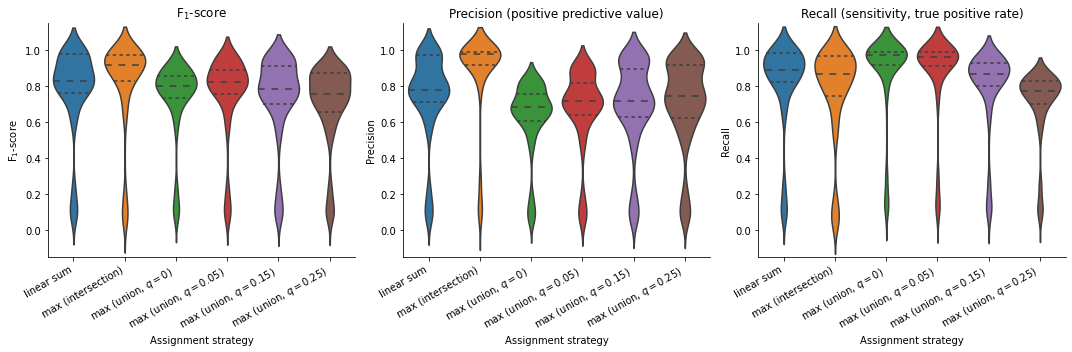

In [9]:
g = sns.catplot(
    x="assignment_name",
    y="metric_value",
    hue="assignment_name",  # avoid warning when setting sharex=False
    hue_order=[
        "linear_sum",
        "max_intersect",
        "max_union",
        "max_union_thresQ05",
        "max_union_thresQ15",
        "max_union_thresQ25",
    ],
    data=df,
    col="metric_name",
    col_order=["f1score","precision", "recall"],
    kind="violin",
    sharex=False,
    sharey=False,
    inner="quartile",
    dodge=False,  # do not dodge, despite setting hue
)
g.set_xticklabels(
    labels=[
        "linear sum",
        "max (intersection)",
        "max (union, $q=0$)",
        "max (union, $q=0.05$)",
        "max (union, $q=0.15$)",
        "max (union, $q=0.25$)",
    ],
    rotation=30,
    ha="right",
)
col_name_titles = {
    "f1score": "$\\mathrm{F_1}$-score",
    "precision": "Precision (positive predictive value)",
    "recall": "Recall (sensitivity, true positive rate)",
}
col_name_ylabels = {
    "f1score": "$\\mathrm{F_1}$-score",
    "precision": "Precision",
    "recall": "Recall",
}
for col_name, ax in zip(g.col_names, g.axes.flat):
    ax.set_title(col_name_titles[col_name])
    ax.set_xlabel("Assignment strategy")
    ax.set_ylabel(col_name_ylabels[col_name])
    ax.set_ylim(-0.15, 1.15)
g.tight_layout()

## Parameter selection

In [10]:
results_info = pd.read_csv("results/results.csv")
df = results_info[
    (results_info["spellmatch_alpha"] != 1)
    #& (results_info["assignment_name"] == "max_intersect")
    & (results_info["metric_name"] == "f1score")
]
df = pd.DataFrame(
    data={
        "alpha": df["spellmatch_alpha"],
        "degree_weight": df["spellmatch_degree_weight"],
        "intensity_weight": df["spellmatch_intensity_weight"],
        "distance_weight": df["spellmatch_distance_weight"],
        "f1score": df["metric_value"],
    }
)

### Degree/intensity/distance weights

In [11]:
x = df.drop(columns="f1score")
y = df["f1score"]
rfr = RandomForestRegressor(bootstrap=False, random_state=123).fit(x, y)
rfr.score(x, y)

0.23070272717391616

In [12]:
pd.Series(rfr.feature_importances_, index=rfr.feature_names_in_, name="Gini importance").sort_values(ascending=False)

intensity_weight    0.381504
degree_weight       0.322690
distance_weight     0.232301
alpha               0.063505
Name: Gini importance, dtype: float64

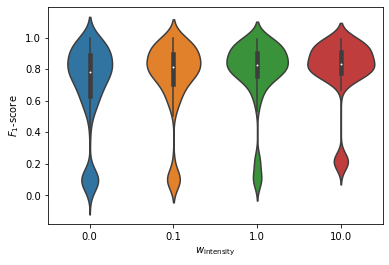

In [13]:
sns.violinplot(
    data=df,
    x="intensity_weight",
    y="f1score",
)
plt.xlabel(r"$w_\mathrm{intensity}$")
plt.ylabel(r"$F_1$-score")
ax.set_ylim(-0.15, 1.15)
plt.show()

$\to$ choose $w_\text{intensity} = 1$ as reference

In [14]:
x = df[df["intensity_weight"] == 1].drop(columns="f1score")
y = df.loc[df["intensity_weight"] == 1, "f1score"]
rfr = RandomForestRegressor(bootstrap=False, random_state=123).fit(x, y)
rfr.score(x, y)

0.22538237635616643

In [15]:
pd.Series(rfr.feature_importances_, index=rfr.feature_names_in_, name="Gini importance").sort_values(ascending=False)

degree_weight       0.745823
distance_weight     0.161873
alpha               0.092304
intensity_weight    0.000000
Name: Gini importance, dtype: float64

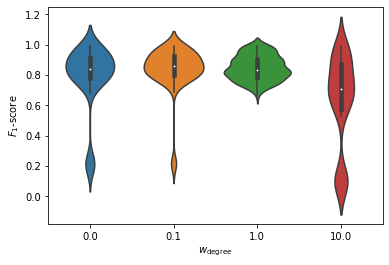

In [16]:
sns.violinplot(
    data=df[df["intensity_weight"] == 1],
    x="degree_weight",
    y="f1score",
)
plt.xlabel(r"$w_\mathrm{degree}$")
plt.ylabel(r"$F_1$-score")
ax.set_ylim(-0.15, 1.15)
plt.show()

$\to$ choose $w_\text{degree} = 1$

In [17]:
x = df[(df["intensity_weight"] == 1) & (df["degree_weight"] == 1)].drop(columns="f1score")
y = df.loc[(df["intensity_weight"] == 1) & (df["degree_weight"] == 1), "f1score"]
rfr = RandomForestRegressor(bootstrap=False, random_state=123).fit(x, y)
rfr.score(x, y)

0.04759284209236192

In [18]:
pd.Series(rfr.feature_importances_, index=rfr.feature_names_in_, name="Gini importance").sort_values(ascending=False)

distance_weight     0.520376
alpha               0.479624
degree_weight       0.000000
intensity_weight    0.000000
Name: Gini importance, dtype: float64

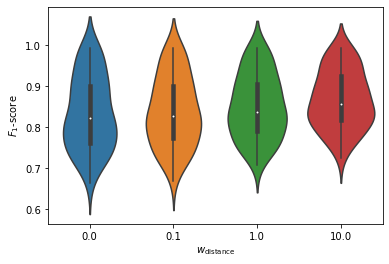

In [19]:
sns.violinplot(
    data=df[(df["intensity_weight"] == 1) & (df["degree_weight"] == 1)],
    x="distance_weight",
    y="f1score",
)
plt.xlabel(r"$w_\mathrm{distance}$")
plt.ylabel(r"$F_1$-score")
ax.set_ylim(-0.15, 1.15)
plt.show()

$\to$ choose $w_\text{distance} = 10$

### Prior importance

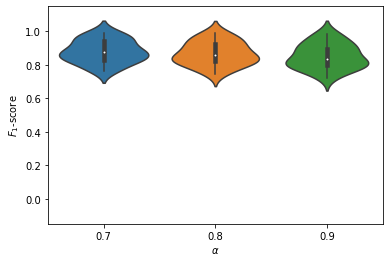

In [20]:
sns.violinplot(
    data=df[
        (df["intensity_weight"] == 1)
        & (df["degree_weight"] == 1)
        & (df["distance_weight"] == 10)
    ],
    x="alpha",
    y="f1score",
)
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$F_1$-score")
plt.ylim(-0.15, 1.15)
plt.show()

$\to$ choose $\alpha = 0.8$ (second-best, to not rely on spatial alignment pior too much)

## Assignment strategy (post-selection)

In [21]:
results_info = pd.read_csv("results/results.csv")
df = results_info[
    (results_info["spellmatch_degree_weight"] == 1)
    & (results_info["spellmatch_intensity_weight"] == 1)
    & (results_info["spellmatch_distance_weight"] == 10)
    & (results_info["spellmatch_alpha"] == 0.8)
]

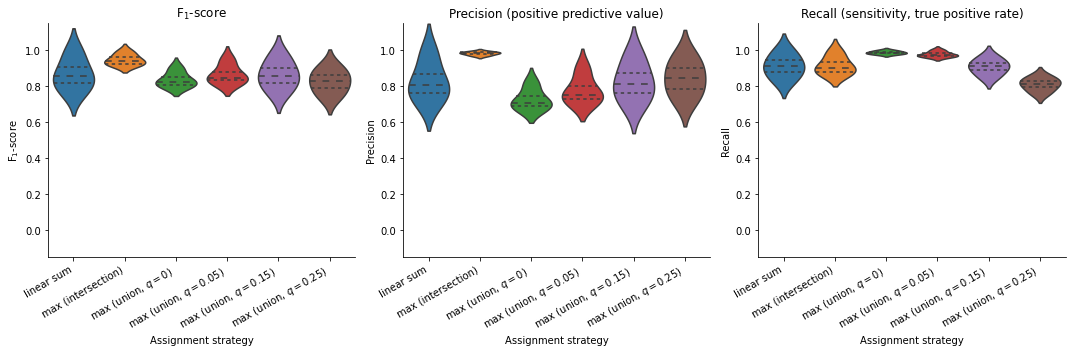

In [22]:
g = sns.catplot(
    x="assignment_name",
    y="metric_value",
    hue="assignment_name",  # avoid warning when setting sharex=False
    hue_order=[
        "linear_sum",
        "max_intersect",
        "max_union",
        "max_union_thresQ05",
        "max_union_thresQ15",
        "max_union_thresQ25",
    ],
    data=df,
    col="metric_name",
    col_order=["f1score","precision", "recall"],
    kind="violin",
    sharex=False,
    sharey=False,
    inner="quartile",
    dodge=False,  # do not dodge, despite setting hue
)
g.set_xticklabels(
    labels=[
        "linear sum",
        "max (intersection)",
        "max (union, $q=0$)",
        "max (union, $q=0.05$)",
        "max (union, $q=0.15$)",
        "max (union, $q=0.25$)",
    ],
    rotation=30,
    ha="right",
)
col_name_titles = {
    "f1score": "$\\mathrm{F_1}$-score",
    "precision": "Precision (positive predictive value)",
    "recall": "Recall (sensitivity, true positive rate)",
}
col_name_ylabels = {
    "f1score": "$\\mathrm{F_1}$-score",
    "precision": "Precision",
    "recall": "Recall",
}
for col_name, ax in zip(g.col_names, g.axes.flat):
    ax.set_title(col_name_titles[col_name])
    ax.set_xlabel("Assignment strategy")
    ax.set_ylabel(col_name_ylabels[col_name])
    ax.set_ylim(-0.15, 1.15)
g.tight_layout()

## Matching performance/uncertainty

In [23]:
results_info = pd.read_csv("results/results.csv")
df = results_info[
    (results_info["spellmatch_degree_weight"] == 1)
    & (results_info["spellmatch_intensity_weight"] == 1)
    & (results_info["spellmatch_distance_weight"] == 10)
    & (results_info["spellmatch_alpha"] == 0.8)
    & (results_info["assignment_name"] == "max_intersect")
]

In [24]:
df.pivot(index=["points_file_name"], columns="metric_name", values="metric_value")[
    [
        "f1score", "precision", "recall",
        "uncertainty_mean", "uncertainty_std",
        "margin_mean", "margin_std",
        "entropy_mean", "entropy_std",
    ]
]

metric_name,f1score,precision,recall,uncertainty_mean,uncertainty_std,margin_mean,margin_std,entropy_mean,entropy_std
points_file_name,,,,,,,,,
dense_heterogeneous.csv,0.926489,0.982213,0.876749,0.695626,0.036924,0.027232,0.021186,6.612409,1.974454
dense_homogeneous.csv,0.953385,0.987696,0.921377,0.448268,0.068796,0.063245,0.040413,7.533058,1.422061
sparse_heterogeneous.csv,0.923505,0.970760,0.880637,0.655693,0.179116,0.071565,0.071364,2.654181,1.995072
sparse_homogeneous.csv,0.989831,0.993197,0.986486,0.733549,0.216586,0.143107,0.071064,0.455596,0.334950
